<a href="https://colab.research.google.com/github/Arif111866/Deep-Learning-AI/blob/main/Assignment_9/Tassk_5_Assignment_9_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torchvision.transforms as transforms

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),          # random crop
    transforms.RandomHorizontalFlip(),             # horizontal flip
    transforms.RandomRotation(10),                 # slight rotation
    transforms.ColorJitter(brightness=0.2),        # brightness change
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])


In [3]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 170M/170M [00:03<00:00, 48.5MB/s]


In [4]:
import torchvision.models as models
import torch.nn as nn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Replace final FC layer for CIFAR-10 (10 classes)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


In [5]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last layer/block
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True


In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss/len(train_loader):.4f} - Acc: {100 * correct / total:.2f}%")



Epoch 1/15 - Loss: 1.5692 - Acc: 44.23%
Epoch 2/15 - Loss: 1.3149 - Acc: 53.36%
Epoch 3/15 - Loss: 1.2267 - Acc: 56.71%
Epoch 4/15 - Loss: 1.1721 - Acc: 58.65%
Epoch 5/15 - Loss: 1.1337 - Acc: 60.07%
Epoch 6/15 - Loss: 1.1049 - Acc: 60.73%
Epoch 7/15 - Loss: 1.0781 - Acc: 61.98%
Epoch 8/15 - Loss: 1.0517 - Acc: 62.56%
Epoch 9/15 - Loss: 1.0392 - Acc: 63.21%
Epoch 10/15 - Loss: 1.0188 - Acc: 63.96%
Epoch 11/15 - Loss: 1.0133 - Acc: 64.19%
Epoch 12/15 - Loss: 0.9954 - Acc: 64.77%
Epoch 13/15 - Loss: 0.9864 - Acc: 65.12%
Epoch 14/15 - Loss: 0.9669 - Acc: 65.58%
Epoch 15/15 - Loss: 0.9562 - Acc: 66.02%


In [7]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy (Pretrained + Augmentation): {100 * correct / total:.2f}%")


Test Accuracy (Pretrained + Augmentation): 67.31%


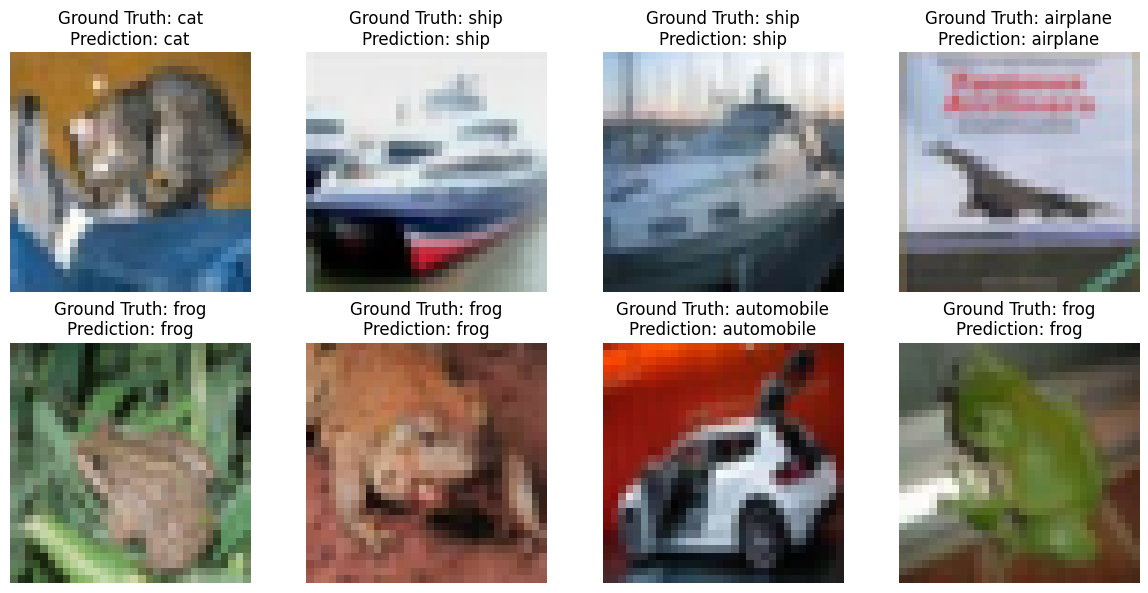

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Get some test samples
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = outputs.max(1)

# Move back to CPU for visualization
images = images.cpu()
labels = labels.cpu()
preds = preds.cpu()

class_names = train_dataset.classes  # ['airplane', 'automobile', ...]

plt.figure(figsize=(12,6))
for i in range(8):  # Show 8 samples
    plt.subplot(2,4,i+1)
    img = images[i].permute(1,2,0).numpy()
    plt.imshow(img)
    plt.title(f"Ground Truth: {class_names[labels[i]]}\nPrediction: {class_names[preds[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [15]:
import matplotlib.pyplot as plt

train_losses = [
    1.5692, 1.3149, 1.2267, 1.1721, 1.1337,
    1.1049, 1.0781, 1.0517, 1.0392, 1.0188,
    1.0133, 0.9954, 0.9864, 0.9669, 0.9562
]

train_accuracies = [
    44.23, 53.36, 56.71, 58.65, 60.07,
    60.73, 61.98, 62.56, 63.21, 63.96,
    64.19, 64.77, 65.12, 65.58, 66.02
]

epochs = list(range(1, 16))


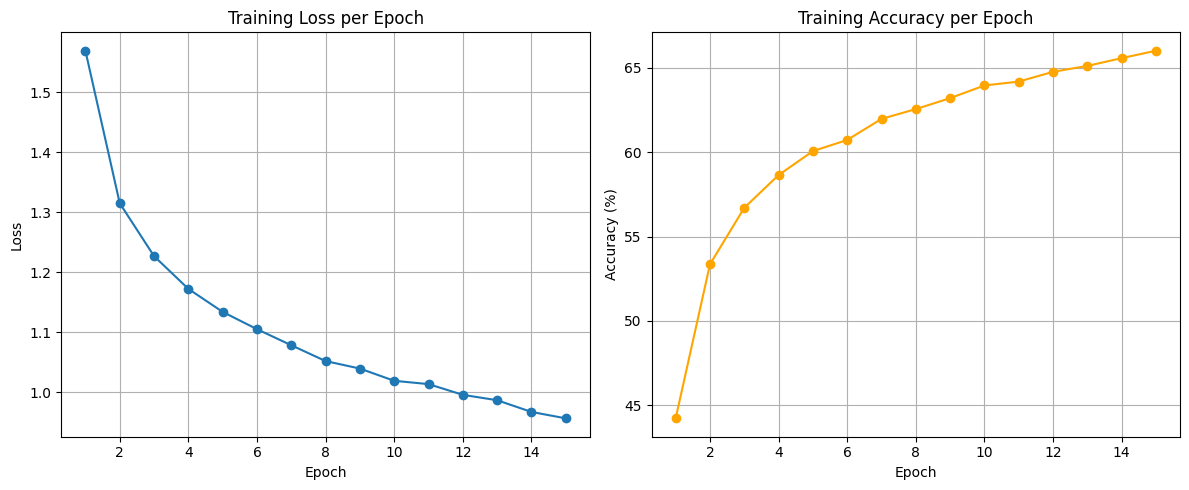

In [16]:
plt.figure(figsize=(12, 5))

# Training Loss Curve
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o', label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Training Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, marker='o', color='orange', label='Training Accuracy')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)

plt.tight_layout()
plt.show()
